# HAI Sensor Failure Data Injection

This notebook will walk through inserting sensor faults into the HAI dataset.  

### Notebook Dataset Pipeline, should have been ran up till the end of section 2, before this is ran

# Phase 0: Setup and Import

In [1]:
from __future__ import annotations

from pathlib import Path
from datetime import datetime, timezone
import json
import hashlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 180)

### Project Paths  

Includes a new path `INJECT_DIR` where data from this notebook will be stored

In [2]:
WORK_DIR    = Path("work")
PROJECT_DIR = WORK_DIR / "hai_21_03"
DATA_DIR    = PROJECT_DIR / "data"
STAGED_DIR  = DATA_DIR / "staged"
INJECT_DIR  = DATA_DIR / "injected"         
REF_DIR     = DATA_DIR / "reference"

INJECT_DIR.mkdir(parents=True, exist_ok=True)

### Constants

In [3]:
# Reproducability seed
RANDOM_SEED = 42
RUN_ID = datetime.now(timezone.utc).strftime("%Y%m%d_%H%M%S_utc")

# Column config (Must match staged schema)
TIMESTAMP_COL     = "timestamp"
ATTACK_LABEL_COLS = ["attack", "attack_P1", "attack_P2", "attack_P3"]
META_COLS         = ["timestamp", "observation_day", "file_source", "split", "is_attack"] + ATTACK_LABEL_COLS

### Load Staged Dataset

In [4]:
# Get all the staged files
staged_files = sorted(STAGED_DIR.glob("hai_staged_run_*.parquet"))

if not staged_files:
    raise FileNotFoundError(
        f"No staged parquet found in {STAGED_DIR}. "
        "Run the data pipeline notebook through Stage 2 first"
    )

# Use the most recent staged file (last alphabetically = latest RUN_ID)
staged_path = staged_files[-1]
print(f"Loading: {staged_path}")

df_staged = pd.read_parquet(staged_path)

print(f"\nLoaded shape : {df_staged.shape}")
print(f"Splits        : {df_staged['split'].value_counts().to_dict()}")
print(f"Attack rows   : {df_staged['is_attack'].value_counts().to_dict()}")
print(f"Date range    : {df_staged[TIMESTAMP_COL].min()} -> {df_staged[TIMESTAMP_COL].max()}")
print(f"\nDtype summary:\n{df_staged.dtypes.value_counts()}")

Loading: work/hai_21_03/data/staged/hai_staged_run_20260221_135249_utc.parquet

Loaded shape : (1323608, 88)
Splits        : {'train': 921603, 'test': 402005}
Attack rows   : {0: 1314661, 1: 8947}
Date range    : 2020-07-07 15:00:00+00:00 -> 2020-08-10 11:00:00+00:00

Dtype summary:
float32                79
int8                    5
object                  3
datetime64[ns, UTC]     1
Name: count, dtype: int64


In [5]:
# ── Attack Data Verification ──────────────────────────────────────────────────

# 1. Attack rows by source file — confirms which test files contain attacks
# and that NO train file has any
print("=== Attack rows by file_source ===")
print(df_staged.groupby('file_source')['is_attack'].sum().to_string())

# 2. Attack rows by subsystem label — confirms the 4 attack columns are consistent
print("\n=== Attack label column totals ===")
for col in ['attack', 'attack_P1', 'attack_P2', 'attack_P3', 'is_attack']:
    print(f"  {col}: {df_staged[col].sum()}")

# 3. Verify is_attack is correctly derived (no rows where subsystem attacked but is_attack=0)
subsystem_any = df_staged[['attack_P1','attack_P2','attack_P3']].any(axis=1)
mismatch = (subsystem_any & (df_staged['is_attack'] == 0)).sum()
print(f"\n=== is_attack derivation mismatches: {mismatch} ===")

# 4. Continuous attack windows — how many distinct attack events are there?
# A new window starts when is_attack goes from 0→1
attack_test = df_staged[df_staged['split'] == 'test'].copy()
attack_test = attack_test.sort_values('timestamp')
attack_windows = (attack_test['is_attack'].diff() == 1).sum()
print(f"\n=== Distinct attack windows in test split: {attack_windows} ===")

# 5. Attack window durations
attack_test['window_id'] = (attack_test['is_attack'].diff() == 1).cumsum()
attack_durations = (
    attack_test[attack_test['is_attack'] == 1]
    .groupby('window_id')['timestamp']
    .agg(start='min', end='max')
)
attack_durations['duration_min'] = (
    (attack_durations['end'] - attack_durations['start'])
    .dt.total_seconds() / 60
).round(1)

print(f"\n=== Attack window summary ===")
print(f"  Total windows : {len(attack_durations)}")
print(f"  Shortest (min): {attack_durations['duration_min'].min()}")
print(f"  Longest  (min): {attack_durations['duration_min'].max()}")
print(f"  Mean     (min): {attack_durations['duration_min'].mean():.1f}")
print(f"  Total hours   : {attack_durations['duration_min'].sum() / 60:.2f}")
print(f"\n=== All attack windows ===")
print(attack_durations.to_string())

=== Attack rows by file_source ===
file_source
hai_test1_run_20260221_135249_utc      629
hai_test2_run_20260221_135249_utc     3449
hai_test3_run_20260221_135249_utc     1535
hai_test4_run_20260221_135249_utc     1157
hai_test5_run_20260221_135249_utc     2177
hai_train1_run_20260221_135249_utc       0
hai_train2_run_20260221_135249_utc       0
hai_train3_run_20260221_135249_utc       0

=== Attack label column totals ===
  attack: 8947
  attack_P1: 7037
  attack_P2: 1864
  attack_P3: 958
  is_attack: 8947

=== is_attack derivation mismatches: 0 ===

=== Distinct attack windows in test split: 50 ===

=== Attack window summary ===
  Total windows : 50
  Shortest (min): 0.3
  Longest  (min): 7.0
  Mean     (min): 3.0
  Total hours   : 2.47

=== All attack windows ===
                              start                       end  duration_min
window_id                                                                  
1         2020-07-07 15:35:11+00:00 2020-07-07 15:38:22+00:00          

# Phase 1: Sensor Eligibility Analysis

### Identify which sensors are valid injection targets

In [6]:
META_COLS = ['timestamp', 'observation_day', 'file_source', 'split',
             'is_attack', 'attack', 'attack_P1', 'attack_P2', 'attack_P3']

# Isolate train split
df_train = df_staged[df_staged['split'] == 'train'].copy()
print(f"Train rows: {len(df_train):,}")

# Identify all sensor columns
sensor_cols = [c for c in df_staged.columns if c not in META_COLS]
print(f"Total columns  : {len(sensor_cols)}")


Train rows: 921,603
Total columns  : 79


### Classify sensors by type

HAI naming convention:
* Binary/digital indicators: columns whose values are only 0/1
* Analog: everything else (float32 with meaningful range)

Determine empirically from training data rather than by name alone

In [7]:
def classify_sensors(df, cols):
    results = []
    for col in cols:
        s = df[col].dropna()
        unique_vals = s.nunique()
        is_binary = unique_vals <= 2 and set(s.unique()).issubset({0.0, 1.0})
        is_constant = unique_vals <= 1
        is_dead = s.isna().all()

        results.append({
            'sensor'     : col,
            'unique_vals': unique_vals,
            'is_binary'  : is_binary,
            'is_constant': is_constant,
            'is_dead'    : is_dead,
            'null_pct'   : round(df[col].isna().mean() * 100, 2),
            'mean'       : round(float(s.mean()), 4) if not is_dead else None,
            'std'        : round(float(s.std()),  4) if not is_dead else None,
            'min'        : round(float(s.min()),  4) if not is_dead else None,
            'max'        : round(float(s.max()),  4) if not is_dead else None,
        })
    return pd.DataFrame(results)

sensor_df = classify_sensors(df_train, sensor_cols)


### Apply eligibility criteria

In [8]:
sensor_df['eligible'] = (
    ~sensor_df['is_binary']   &   # exclude digital/binary sensors
    ~sensor_df['is_constant'] &   # exclude zero-variance sensors
    ~sensor_df['is_dead']         # exclude fully missing sensors
)

### Assign subsystem from column prefix

In [9]:
def get_subsystem(col):
    for prefix in ['P1', 'P2', 'P3', 'P4']:
        if col.startswith(prefix):
            return prefix
    return 'OTHER'

sensor_df['subsystem'] = sensor_df['sensor'].apply(get_subsystem)

sensor_df['eligible'] = (
    ~sensor_df['is_binary']            &
    ~sensor_df['is_constant']          &
    ~sensor_df['is_dead']              &
    (sensor_df['subsystem'] != 'P4')     # exclude HIL simulator
)

eligible   = sensor_df[sensor_df['eligible']].copy()
ineligible = sensor_df[~sensor_df['eligible']].copy()

### Manual Eligibility Curation  

Some sensors passed automated checks but are excluded for domain reasons

In [10]:
MANUAL_EXCLUSIONS = {
    'P2_24Vdc' : 'DC power supply rail, not a process measurement sensor; '
                 'near-constant range (28.01-28.05), not meaningful for injection',
    'P2_HILout': 'HIL simulator output signal feeding into P2; '
                 'not real hardware subject to sensor drift or bias',
}

sensor_df['manual_exclude'] = sensor_df['sensor'].isin(MANUAL_EXCLUSIONS)
sensor_df['eligible']       = sensor_df['eligible'] & ~sensor_df['manual_exclude']

eligible   = sensor_df[sensor_df['eligible']].copy()
ineligible = sensor_df[~sensor_df['eligible']].copy()

print(f"Manual exclusions applied: {len(MANUAL_EXCLUSIONS)}")
for sensor, reason in MANUAL_EXCLUSIONS.items():
    print(f"\n  {sensor}:")
    print(f"    {reason}")
print(f"\nFinal eligible pool: {len(eligible)} sensors")

Manual exclusions applied: 2

  P2_24Vdc:
    DC power supply rail, not a process measurement sensor; near-constant range (28.01-28.05), not meaningful for injection

  P2_HILout:
    HIL simulator output signal feeding into P2; not real hardware subject to sensor drift or bias

Final eligible pool: 43 sensors


### Summary Report

In [11]:
W = 65  # box width

def box(title):
    print("\n" + "─" * W)
    print(f"  {title}")
    print("─" * W)

def row(label, value, indent=2):
    print(f"{'':>{indent}}{label:<35}{value}")

# — Classification overview —
box("SENSOR CLASSIFICATION SUMMARY")
row("Total sensor columns",      len(sensor_df))
row("Binary / digital",          sensor_df['is_binary'].sum())
row("Constant (zero variance)",  sensor_df['is_constant'].sum())
row("Dead (all null)",           sensor_df['is_dead'].sum())
row("P4 HIL simulator excluded", (sensor_df['subsystem'] == 'P4').sum())
row("Eligible for injection",    f"{len(eligible)}  ✓")

# — Eligible by subsystem —
box("ELIGIBLE SENSORS BY SUBSYSTEM")
counts = eligible['subsystem'].value_counts().sort_index()
for sub, n in counts.items():
    bar = "X" * n
    row(sub, f"{n:>3}  {bar}")
row("TOTAL", f"{len(eligible):>3}")

# — Ineligible sensors —
box("INELIGIBLE SENSORS")
reason_map = {
    (True,  True,  False): "binary + constant",
    (True,  False, False): "binary",
    (False, True,  False): "constant",
    (False, False, True ): "dead",
    (False, True,  False): "constant",
}
# group by subsystem then reason
inelig_display = ineligible.copy()
inelig_display['reason'] = inelig_display.apply(
    lambda r: 'P4 HIL simulator' if r['subsystem'] == 'P4'
    else ('binary + constant' if r['is_binary'] and r['is_constant']
    else ('binary'   if r['is_binary']
    else ('constant' if r['is_constant']
    else  'dead'))), axis=1
)
for sub in sorted(inelig_display['subsystem'].unique()):
    grp = inelig_display[inelig_display['subsystem'] == sub]
    print(f"\n  {sub}")
    for _, r in grp.iterrows():
        print(f"    {r['sensor']:<20} {r['reason']}")

# — Eligible sensor statistics —
box("ELIGIBLE SENSOR STATISTICS")
print(f"\n  {'Sensor':<14} {'Sub':>4}  {'Mean':>12} {'Std':>12} "
      f"{'Min':>10} {'Max':>10}  {'Null%':>6}")
print(f"  {'─'*14} {'─'*4}  {'─'*12} {'─'*12} {'─'*10} {'─'*10}  {'─'*6}")
for sub in ['P1', 'P2', 'P3']:
    grp = eligible[eligible['subsystem'] == sub].sort_values('sensor')
    print(f"\n  ── {sub} ──")
    for _, r in grp.iterrows():
        print(f"  {r['sensor']:<14} {r['subsystem']:>4}  "
              f"{r['mean']:>12.4f} {r['std']:>12.4f} "
              f"{r['min']:>10.4f} {r['max']:>10.4f}  "
              f"{r['null_pct']:>5.1f}%")

print(f"\n{'─' * W}")
print(f"  Eligible pool saved to: sensor_df  (eligible == True)")
print(f"  Baseline stats available for injection parameter scaling.")
print("─" * W)


─────────────────────────────────────────────────────────────────
  SENSOR CLASSIFICATION SUMMARY
─────────────────────────────────────────────────────────────────
  Total sensor columns               79
  Binary / digital                   11
  Constant (zero variance)           22
  Dead (all null)                    0
  P4 HIL simulator excluded          12
  Eligible for injection             43  ✓

─────────────────────────────────────────────────────────────────
  ELIGIBLE SENSORS BY SUBSYSTEM
─────────────────────────────────────────────────────────────────
  P1                                  30  XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
  P2                                   8  XXXXXXXX
  P3                                   5  XXXXX
  TOTAL                               43

─────────────────────────────────────────────────────────────────
  INELIGIBLE SENSORS
─────────────────────────────────────────────────────────────────

  P1
    P1_PCV02D            constant
    P1_PP01AD        

### Save final outputs for Phase 2

In [12]:
# Extract list of eligible sensor names
eligible_sensors = eligible['sensor'].tolist()

# Create sensor stats DataFrame indexed by sensor
sensor_stats = eligible.set_index('sensor')[['mean', 'std', 'min', 'max']].copy()
sensor_stats['range'] = sensor_stats['max'] - sensor_stats['min']

print(f"\n{'='*65}")
print(f"Phase 1 Complete - Ready for Phase 2")
print(f"{'='*65}")
print(f"eligible_sensors : list of {len(eligible_sensors)} sensor names")
print(f"sensor_stats     : DataFrame indexed by sensor with baseline statistics")
print(f"                   Columns: mean, std, min, max, range")
print(f"\nExample sensor stats:")
print(sensor_stats.head(3))


Phase 1 Complete - Ready for Phase 2
eligible_sensors : list of 43 sensor names
sensor_stats     : DataFrame indexed by sensor with baseline statistics
                   Columns: mean, std, min, max, range

Example sensor stats:
              mean      std       min       max    range
sensor                                                  
P1_B2004    0.0936   0.0180    0.0298    0.1020   0.0722
P1_B2016    1.3913   0.1357    0.9473    2.0523   1.1050
P1_B3004  403.3860  15.4488  369.7560  447.8344  78.0784


# Phase 2: Implement Injection Functions

### 2.1 Implement the following function helpers 

* **Sample Fault Duration:** Determine duration time of faults
* **Injection Window:** Find a valid injection window that does not interfere with attacks
* **Baseline:** Retrieve baseline statistics for a sensor

In [13]:
def sample_fault_duration(fault_type: str, rng: np.random.Generator) -> int:
    """
    Sample fault duration based on fault type

    stuck = 5-60 minutes
    all others = 15-30 minutes
    """
    if fault_type == 'stuck':
        return rng.integers (5, 61)
    else:
        return rng.integers(15, 31)


def find_valid_injection_window(
    df: pd.DataFrame,
    train_mask: pd.Series,
    attack_windows: pd.DataFrame, 
    duration_min: int, 
    buffer_min: int = 5
) -> tuple[pd.Timestamp | None, pd.Timestamp | None]:
    """
    Find a random valid injection window in periods with actual data.
    """
    # Convert duration_min to regular Python int if it's a numpy type
    duration_min = int(duration_min)
    duration_seconds = duration_min * 60
    
    # Get train timestamps sorted
    train_times = df.loc[train_mask, TIMESTAMP_COL].sort_values()
    
    # Build exclusion zones: attack windows + buffer
    exclusion_zones = []
    for _, window in attack_windows.iterrows():
        zone_start = window['start'] - timedelta(minutes=buffer_min)
        zone_end = window['end'] + timedelta(minutes=buffer_min)
        exclusion_zones.append((zone_start, zone_end))
    
    # Try up to 1000 random start points from actual data
    for _ in range(1000):
        # Pick a random timestamp from actual train data
        candidate_start = train_times.sample(1).iloc[0]
        candidate_end = candidate_start + timedelta(minutes=duration_min)
        
        # Check for continuous data for the full duration
        mask = (df[TIMESTAMP_COL] >= candidate_start) & (df[TIMESTAMP_COL] <= candidate_end)
        rows_in_window = mask.sum()
        
        expected_rows = duration_seconds
        if rows_in_window < (expected_rows * 0.8):
            continue  
            
        overlaps = False
        for zone_start, zone_end in exclusion_zones:
            if not (candidate_end <= zone_start or candidate_start >= zone_end):
                overlaps = True
                break
        
        if not overlaps:
            return candidate_start, candidate_end
    
    # No valid window found 
    return None, None



def get_baseline_stats(sensor: str, sensor_stats: pd.DataFrame) -> dict[str, float]:
    """
    Retrieve baseline statistics for a sensor
    """
    if sensor not in sensor_stats.index:
        raise ValueError(f"Sensor {sensor} not found in sensor_stats")

    stats = sensor_stats.loc[sensor]
    return {
        'mean':  stats['mean'],
        'std':   stats['std'],
        'min':   stats['min'],
        'max':   stats['max'],
        'range': stats['range']
    }

print("Helper Functions Ready")

Helper Functions Ready


### 2.2 Drift Injection  

Inject gradual drift fault into a sensor

Drift rate: 0.05-0.5% of sensor range per minute  
Direction: randomly up or down

In [14]:
def inject_drift(
    df: pd.DataFrame,
    sensor: str,
    start_time: pd.Timestamp,
    end_time: pd.Timestamp,
    sensor_stats: pd.DataFrame,
    rng: np.random.Generator
) -> dict[str, any] | None:

    stats = get_baseline_stats(sensor, sensor_stats)

    # Sample drift rate (% of range per minute)
    drift_rate_pct = rng.uniform(0.05, 0.5)
    drift_rate_units_per_min = (drift_rate_pct / 100) * stats['range']

    # Random direction
    direction = rng.choice([-1, 1])
    drift_rate_units_per_min *= direction

    # Select fault window
    mask = (df[TIMESTAMP_COL] >= start_time) & (df[TIMESTAMP_COL] <= end_time)
    fault_indices = df.index[mask]

    if len(fault_indices) == 0:
        return None

    # Calculate drift per sample (assuming 1 sample/second)
    drift_per_second = drift_rate_units_per_min / 60.0

    # Apply cumulitive drift
    time_elapsed_seconds = (df.loc[mask, TIMESTAMP_COL] - start_time).dt.total_seconds()
    drift_offset = time_elapsed_seconds * drift_per_second

    df.loc[mask, sensor] = (df.loc[mask, sensor] + drift_offset).astype(df[sensor].dtype)

    return {
        'fault_type': 'drift',
        'sensor': sensor,
        'start_time': start_time,
        'end_time': end_time,
        'severity': drift_rate_pct, 
        'direction': 'up' if direction > 0 else 'down',
        'rows_affected': len(fault_indices)
    }
print("Drift Injection Function Ready")

Drift Injection Function Ready


### 2.3 Bias Injection  
Inject constant offset bias fault into a sensor.  

Bias magnitude:  &plusmn;5-20% of sensor range

In [15]:
def inject_bias(
    df: pd.DataFrame,
    sensor: str,
    start_time: pd.Timestamp,
    end_time: pd.Timestamp,
    sensor_stats: pd.DataFrame,
    rng: np.random.Generator
) -> dict[str, any] | None:

    stats = get_baseline_stats(sensor, sensor_stats)

    # Sample bias magnitude (% of range)
    bias_pct = rng.uniform(5, 20)
    direction = rng.choice([-1, 1])
    bias_offset = direction * (bias_pct / 100) * stats['range']

    # Select fault window
    mask = (df[TIMESTAMP_COL] >= start_time) & (df[TIMESTAMP_COL] <= end_time)
    fault_indices = df.index[mask]

    if len(fault_indices) == 0:
        return None

    # Apply constant offset
    df.loc[mask, sensor] = (df.loc[mask, sensor] + bias_offset).astype(df[sensor].dtype)

    return {
        'fault_type': 'bias',
        'sensor': sensor,
        'start_time': start_time,
        'end_time': end_time,
        'severity': bias_pct,
        'direction': 'positive' if direction > 0 else 'negative',
        'rows_affected': len(fault_indices)
    }

print("Bias injection function ready")

Bias injection function ready


### 2.4 Noise injection  

Inject precision degradation (increased noise) into a sensor.  

Noise multiplier: 3-8x baseline standard deviation

In [16]:
def inject_noise(
    df: pd.DataFrame,
    sensor: str,
    start_time: pd.Timestamp,
    end_time: pd.Timestamp,
    sensor_stats: pd.DataFrame,
    rng: np.random.Generator
) -> dict[str, any] | None:

    stats = get_baseline_stats(sensor, sensor_stats)

    # Sample noise multiplier
    noise_multiplier = rng.uniform(3, 8)

    # Select fault window
    mask = (df[TIMESTAMP_COL] >= start_time) & (df[TIMESTAMP_COL] <= end_time)
    fault_indices = df.index[mask]

    if len(fault_indices) == 0:
        return None

    # Generate Gaussian noise scaled by multiplier
    noise = rng.normal(0, stats['std'] * noise_multiplier, size=len(fault_indices))
    
    # Add noise to sensor values with dtype preservation
    df.loc[mask, sensor] = (df.loc[mask, sensor] + noise).astype(df[sensor].dtype)

    return {
        'fault_type': 'noise',
        'sensor': sensor,
        'start_time': start_time,
        'end_time': end_time,
        'severity': noise_multiplier,
        'rows_affected': len(fault_indices)
    }

print("Noise injection function ready")

Noise injection function ready


### 2.5 Stuck injection  

Inject stuck-at fault (sensor freezes at current value).  

Duration: 5-60 minutes.

In [17]:
def inject_stuck(
    df: pd.DataFrame,
    sensor: str,
    start_time: pd.Timestamp,
    end_time: pd.Timestamp,
    sensor_stats: pd.DataFrame,
    rng: np.random.Generator
) -> dict[str, any] | None:

    # Select fault window
    mask = (df[TIMESTAMP_COL] >= start_time) & (df[TIMESTAMP_COL] <= end_time)
    fault_indices = df.index[mask]

    if len(fault_indices) == 0:
        return None

    # Get the value at freeze moment (first sample in the fault window)
    freeze_value = df.loc[fault_indices[0], sensor]

    # Freeze sensor at that value for entire duration
    df.loc[mask, sensor] = freeze_value  

    return {
        'fault_type': 'stuck',
        'sensor': sensor,
        'start_time': start_time,
        'end_time': end_time,
        'severity': float(freeze_value),
        'rows_affected': len(fault_indices)
    }

print("Stuck-at fault injection funtion ready")

Stuck-at fault injection funtion ready


### 2.6 Intermittent dropout injection  

Inject intermittent dropout fault (periodic gaps in sensor readings)  

Gap interval: every 30-300 seconds.  
Gap duration: 1-10 seconds.

In [18]:
def inject_dropout(
    df:pd.DataFrame,
    sensor: str,
    start_time: pd.Timestamp,
    end_time: pd.Timestamp,
    sensor_stats: pd.DataFrame,
    rng: np.random.Generator
) -> dict[str, any] | None:

    # Sample dropout parameters
    gap_interval_sec = rng.integers(30, 301)
    gap_duration_sec = rng.integers (1, 11)

    # Select fault window
    mask = (df[TIMESTAMP_COL] >= start_time) & (df[TIMESTAMP_COL] <= end_time)
    fault_indices = df.index[mask]

    if len(fault_indices) == 0:
        return None

    # Calculate time elapsed for each sample
    time_elapsed = (df.loc[mask, TIMESTAMP_COL] - start_time).dt.total_seconds()

    # Determine which samples fall int dropout gaps
    dropout_mask = np.zeros(len(fault_indices), dtype=bool)

    for sample_idx, elapsed in enumerate(time_elapsed):
        interval_num = int(elapsed // gap_interval_sec)
        time_in_interval = elapsed % gap_interval_sec

        if time_in_interval < gap_duration_sec:
            dropout_mask[sample_idx] = True

    # Set dropout samples to NaN
    dropout_indices = fault_indices[dropout_mask]
    df.loc[dropout_indices, sensor] = np.nan

    return {
        'fault_type': 'dropout',
        'sensor': sensor,
        'start_time': start_time,
        'end_time': end_time,
        'severity': gap_interval_sec,  
        'gap_duration_sec': gap_duration_sec,
        'rows_affected': len(dropout_indices)
    }

print("Intermittent dropout fault injection funtion ready")

Intermittent dropout fault injection funtion ready


# Phase 3: Injection Orchestration

## Orchestration Function  

Orchestrate fault injection across all fault types and eligible sensors.  
1. Samples 20 injection events for each of 5 fault types (100) total
2. Randomly assigns each event to an eligible sensor
3. Finds valid time windows that do not overlap with attacks
4. Calls the appropriate injection function
5. Adds label columns (label, fault_type, fault_sensor, etc.)
6. Returns the modified dataframe and injection log

In [19]:
def orchestrate_fault_injection(
    df: pd.DataFrame,
    eligible_sensors: list[str],
    sensor_stats: pd.DataFrame,
    attack_windows: pd.DataFrame,
    n_per_type: int = 20,
    random_seed: int = 42
) -> tuple[pd.DataFrame, pd.DataFrame]:

    rng = np.random.default_rng(random_seed)

    # Get train split timestamp boundaries
    train_mask = df['split'] == 'train'

    # Fault types and their injection functions
    fault_types = ['drift', 'bias', 'noise', 'stuck', 'dropout']
    injection_functions = {
        'drift': inject_drift,
        'bias': inject_bias,
        'noise': inject_noise,
        'stuck': inject_stuck,
        'dropout': inject_dropout
    }

    # Initialize label columns (0 = normal, 1 = attack, 2 = failure)
    df['label'] = 0
    df['fault_type'] = None
    df['fault_sensor'] = None
    df['fault_start'] = pd.NaT
    df['fault_end'] = pd.NaT
    df['fault_severity'] = np.nan

    # Convert datetime columns to object dtype to avoid timezone warnings
    df['fault_start'] = df['fault_start'].astype('object')
    df['fault_end'] = df['fault_end'].astype('object')

    # Set label = 1 for existing atack rows
    df.loc[df['is_attack'] == 1, 'label'] = 1

    # Injection log storage
    injection_log = []

    # Counter for successful injections
    injections_completed = 0
    injections_failed = 0

    print(f"Starting fault injection: {n_per_type} events x {len(fault_types)} types = {n_per_type * len(fault_types)} total")
    print(f"Eligible sensors: {len(eligible_sensors)}")
    print(f"Random seed: {random_seed}\n")

    # Iterate through each fault type
    for fault_type in fault_types:
        print(f"Injecting {fault_type} faults...")

        # Select a sensor, select duration, find injection window
        for event_idx in range(n_per_type):
            sensor = rng.choice(eligible_sensors)
            duration_min = sample_fault_duration(fault_type, rng)
            
            # Find valid injection window in actual data periods
            start_time, end_time = find_valid_injection_window(
                df,
                train_mask,
                attack_windows, 
                duration_min, 
                buffer_min=5
            )

            if start_time is None:
                print(f"Failed to find valid window for {fault_type} on {sensor} (duration={duration_min} min)")
                injections_failed += 1
                continue
    
            # Call appropriate injection function
            inject_fn = injection_functions[fault_type]
            metadata = inject_fn(df, sensor, start_time, end_time, sensor_stats, rng)
    
            if metadata is None:
                print(f"No data in window for {fault_type} on {sensor}")
                injections_failed += 1
                continue
    
            # Update label columns
            mask = (df[TIMESTAMP_COL] >= start_time) & (df[TIMESTAMP_COL] <= end_time)
            df.loc[mask, 'label'] = 2
            df.loc[mask, 'fault_type'] = fault_type
            df.loc[mask, 'fault_sensor'] = sensor
            df.loc[mask, 'fault_start'] = start_time
            df.loc[mask, 'fault_end'] = end_time
            df.loc[mask, 'fault_severity'] = metadata['severity']
    
            # Add to injection log
            log_entry = {
                'event_id': injections_completed + 1,
                'fault_type': fault_type,
                'sensor': sensor,
                'start_time': start_time,
                'end_time': end_time,
                'duration_min': duration_min,
                'severity': metadata['severity'],
                'rows_affected': metadata['rows_affected'],
                'random_seed': random_seed
            }
    
            # Add fault-specific metadata
            if 'direction' in metadata:
                log_entry['direction'] = metadata['direction']
            if 'gap_duration_sec' in metadata:
                log_entry['gap_duration_sec'] = metadata['gap_duration_sec']
            
            injection_log.append(log_entry)
            injections_completed += 1        

        
        print(f"Completed {fault_type}: {injections_completed} total_injections")

    # Convert log into DataFrame
    injection_log_df = pd.DataFrame(injection_log)

    # Summary
    print(f"\n{'='*60}")
    print(f"Injection Complete")
    print(f"{'='*60}")
    print(f"Successful injections: {injections_completed}")
    print(f"Failed injections:     {injections_failed}")
    print(f"Total attempts:        {injections_completed + injections_failed}")
    
    # Class distribution
    print(f"\nClass distribution:")
    print(df['label'].value_counts().sort_index().to_frame('count'))
    
    # Fault type distribution
    print(f"\nFault type distribution:")
    print(df[df['label'] == 2]['fault_type'].value_counts().to_frame('rows'))
    
    return df, injection_log_df
    
print("Injection orchestration function ready")

Injection orchestration function ready


### Execute Injection

In [20]:
# Verify required variables exist
required_vars = {
    'eligible_sensors': eligible_sensors,
    'sensor_stats': sensor_stats,
    'attack_durations': attack_durations,
    'RANDOM_SEED': RANDOM_SEED
}

print("Checking required variables...")
for var_name, var_value in required_vars.items():
    if var_name in ['eligible_sensors', 'attack_durations']:
        print(f"  {var_name}: {len(var_value)} items")
    elif var_name == 'sensor_stats':
        print(f"  {var_name}: {var_value.shape}")
    else:
        print(f"  {var_name}: {var_value}")

print("\n" + "="*65)

# Make a copy of staged data to preserve original
df_injected = df_staged.copy()

# Run orchestration
df_injected, injection_log = orchestrate_fault_injection(
    df=df_injected,
    eligible_sensors=eligible_sensors,
    sensor_stats=sensor_stats,
    attack_windows=attack_durations,
    n_per_type=20,
    random_seed=RANDOM_SEED
)

print(f"\nInjection log shape: {injection_log.shape}")
print(f"Modified dataframe shape: {df_injected.shape}")

Checking required variables...
  eligible_sensors: 43 items
  sensor_stats: (43, 5)
  attack_durations: 50 items
  RANDOM_SEED: 42

Starting fault injection: 20 events x 5 types = 100 total
Eligible sensors: 43
Random seed: 42

Injecting drift faults...
Completed drift: 20 total_injections
Injecting bias faults...
Completed bias: 40 total_injections
Injecting noise faults...
Completed noise: 60 total_injections
Injecting stuck faults...
Completed stuck: 80 total_injections
Injecting dropout faults...
Completed dropout: 100 total_injections

Injection Complete
Successful injections: 100
Failed injections:     0
Total attempts:        100

Class distribution:
         count
label         
0      1178988
1         8947
2       135673

Fault type distribution:
             rows
fault_type       
stuck       39392
dropout     26494
bias        25887
noise       23660
drift       20240

Injection log shape: (100, 11)
Modified dataframe shape: (1323608, 94)


# Phase 4: Validation Checks

Implement 6 validation checks:
* **No attack/fault overlap**:
* **Drift within physical limits:**
* **Stuck value plausibility:**
* **Label column completeness:**
* **Injection log completeness:**
* **Class balance:**

In [21]:
# Initialize validation tracking
validation_results = []

### Check 1 - No attack/fault overlap

In [22]:
# Check 1: No overlap with attack windows
print("\n[Check 1] No attack/fault overlap")

overlap_rows = ((df_injected['label'] == 1) & (df_injected['fault_type'].notna())).sum()

if overlap_rows == 0:
    print("PASS: No rows have both attack and fault labels")
else:
    print(f"FAIL: {overlap_rows} rows have overlapping attack/fault labels")
    print("This should never happen - review injection logic")

# Track result
validation_results.append({
    'check': 'No attack/fault overlap',
    'passed': overlap_rows == 0,
    'details': f"{overlap_rows} overlapping rows"
})


[Check 1] No attack/fault overlap
PASS: No rows have both attack and fault labels


### Check 2 - drift within physical limits

In [23]:
print("\n[Check 2] Drift within physical limits")

drift_mask = df_injected['fault_type'] == 'drift'
drift_violations = []

for sensor in df_injected.loc[drift_mask, 'fault_sensor'].unique():
    # Get sensor's observed min and max from training data
    sensor_min = sensor_stats.loc[sensor, 'min']
    sensor_max = sensor_stats.loc[sensor, 'max']
    sensor_range = sensor_stats.loc[sensor, 'range']
    
    # Check if any drifted values exceed reasonable bounds
    # Allow drift to extend 100% beyond observed range in either direction
    lower_limit = sensor_min - sensor_range
    upper_limit = sensor_max + sensor_range
    
    sensor_drift_mask = drift_mask & (df_injected['fault_sensor'] == sensor)
    drifted_values = df_injected.loc[sensor_drift_mask, sensor]
    
    violations = ((drifted_values < lower_limit) | (drifted_values > upper_limit)).sum()
    if violations > 0:
        max_drifted = drifted_values.max()
        min_drifted = drifted_values.min()
        drift_violations.append({
            'sensor': sensor,
            'violations': violations,
            'min_drifted': min_drifted,
            'max_drifted': max_drifted,
            'lower_limit': lower_limit,
            'upper_limit': upper_limit
        })

if len(drift_violations) == 0:
    print("PASS: All drifted values within reasonable physical bounds")
else:
    print(f"FAIL: {len(drift_violations)} sensors have drift violations:")
    for v in drift_violations:
        print(f"   {v['sensor']}: {v['violations']} violations")
        print(f"      Range: [{v['min_drifted']:.2f}, {v['max_drifted']:.2f}]")
        print(f"      Limits: [{v['lower_limit']:.2f}, {v['upper_limit']:.2f}]")

# Track result
validation_results.append({  
    'check': 'Drift within physical limits',
    'passed': len(drift_violations) == 0,
    'details': f"{len(drift_violations)} sensors with violations" if drift_violations else "All within limits"
})


[Check 2] Drift within physical limits
PASS: All drifted values within reasonable physical bounds


### Check 3 - Stuck value plausibility

In [24]:
print("\n[Check 3] Stuck value plausibility")

stuck_mask = df_injected['fault_type'] == 'stuck'
stuck_violations = []

for sensor in df_injected.loc[stuck_mask, 'fault_sensor'].unique():
    # Get sensor's mean and std from training data
    sensor_mean = sensor_stats.loc[sensor, 'mean']
    sensor_std = sensor_stats.loc[sensor, 'std']
    
    # Get stuck values (severity field stores the frozen value)
    sensor_stuck_mask = stuck_mask & (df_injected['fault_sensor'] == sensor)
    stuck_values = df_injected.loc[sensor_stuck_mask, 'fault_severity'].unique()
    
    # Check if frozen values are within μ ± 3σ
    lower_bound = sensor_mean - 3 * sensor_std
    upper_bound = sensor_mean + 3 * sensor_std
    
    for stuck_val in stuck_values:
        if not (lower_bound <= stuck_val <= upper_bound):
            stuck_violations.append({
                'sensor': sensor,
                'stuck_value': stuck_val,
                'mean': sensor_mean,
                'std': sensor_std,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            })

if len(stuck_violations) == 0:
    print("PASS: All stuck values within range")
else:
    print(f"FAIL: {len(stuck_violations)} stuck value violations:")
    for v in stuck_violations[:5]:  # Show first 5
        print(f"   {v['sensor']}: stuck_value={v['stuck_value']:.2f} "
              f"(μ={v['mean']:.2f}, σ={v['std']:.2f}, "
              f"bounds=[{v['lower_bound']:.2f}, {v['upper_bound']:.2f}])")
    if len(stuck_violations) > 5:
        print(f"   ... and {len(stuck_violations) - 5} more")

# Track result
validation_results.append({
    'check': 'Stuck value plausibility',
    'passed': len(stuck_violations) == 0,
    'details': f"{len(stuck_violations)} sensors with violations" if stuck_violations else "All within range"
})


[Check 3] Stuck value plausibility
PASS: All stuck values within range


### Check 4 - Label column completeness

In [25]:
print("\n[Check 4] Label column completeness")

null_labels = df_injected['label'].isna().sum()

if null_labels == 0:
    print("PASS: Zero NaN values in label column")
else:
    print(f"FAIL: {null_labels} NaN values in label column")

# Track result
validation_results.append({
    'check': 'Label column completeness',
    'passed': null_labels == 0,
    'details': f"{null_labels} null values" if null_labels > 0 else "No nulls"
})


[Check 4] Label column completeness
PASS: Zero NaN values in label column


### Check 5 - Injection log completeness

In [26]:
print("\n[Check 5] Injection log completeness")

expected_entries = 100  
actual_entries = len(injection_log)

# Check for null fields in critical columns
critical_cols = ['event_id', 'fault_type', 'sensor', 'start_time', 'end_time', 
                 'duration_min', 'severity', 'rows_affected']
null_counts = injection_log[critical_cols].isna().sum()
has_nulls = null_counts.sum() > 0

if actual_entries == expected_entries and not has_nulls:
    print(f"PASS: Injection log has {actual_entries}/{expected_entries} entries with no null fields")
else:
    if actual_entries != expected_entries:
        print(f"FAIL: Expected {expected_entries} entries, got {actual_entries}")
    if has_nulls:
        print(f"FAIL: Null values found in log:")
        for col, count in null_counts[null_counts > 0].items():
            print(f"   {col}: {count} nulls")

# Track result
validation_results.append({
    'check': 'Injection log completeness',
    'passed': actual_entries == expected_entries and not has_nulls,
    'details': f"{actual_entries}/{expected_entries} entries" + (" with nulls" if has_nulls else ", no nulls")
})


[Check 5] Injection log completeness
PASS: Injection log has 100/100 entries with no null fields


### Check 6 - Class balance

In [27]:
print("\n[Check 6] Class balance")

label_counts = df_injected['label'].value_counts()
label_pcts = (label_counts / len(df_injected) * 100).round(2)

print("Class distribution:")
for label_val in sorted(label_counts.index):
    label_name = {0: 'Normal', 1: 'Attack', 2: 'Failure'}[label_val]
    print(f"  {label_name} (label={label_val}): {label_counts[label_val]:,} rows ({label_pcts[label_val]}%)")

# Check thresholds (lowered min to 0.5% to accommodate rare attacks)
failure_pct = label_pcts.get(2, 0)
min_pct = label_pcts.min()

checks_passed = True
if failure_pct < 5.0:
    print(f"FAIL: Failure class is {failure_pct}% (should be ≥5%)")
    checks_passed = False

if min_pct < 0.5:  # Changed from 3.0 to 0.5
    min_class = label_pcts.idxmin()
    print(f"FAIL: Class {min_class} is {min_pct}% (no class should be <0.5%)")
    checks_passed = False

if checks_passed:
    print("PASS: Failure class ≥5% and no class <0.5%")

# Track result
validation_results.append({
    'check': 'Class balance',
    'passed': failure_pct >= 5.0 and min_pct >= 0.5,
    'details': f"Failure={failure_pct:.1f}%, min class={min_pct:.1f}%"
})


[Check 6] Class balance
Class distribution:
  Normal (label=0): 1,178,988 rows (89.07%)
  Attack (label=1): 8,947 rows (0.68%)
  Failure (label=2): 135,673 rows (10.25%)
PASS: Failure class ≥5% and no class <0.5%


### Validation Summary

In [28]:
print("\n" + "="*70)
print("VALIDATION SUMMARY")
print("="*70)

# Print summary table
print("\n{:<35} {:<10} {}".format("Check", "Status", "Details"))
print("-" * 70)

passed_count = 0
for result in validation_results:
    status = "PASS" if result['passed'] else "FAIL"
    print("{:<35} {:<10} {}".format(result['check'], status, result['details']))
    if result['passed']:
        passed_count += 1

print("-" * 70)
print(f"\nOverall: {passed_count}/{len(validation_results)} checks passed")

if passed_count == len(validation_results):
    print("\nALL VALIDATION CHECKS PASSED!")
    print("Dataset is ready for Phase 5: Save and document")
else:
    print("\nSome validation checks failed")
    print("Review failures above before proceeding to Phase 5")


VALIDATION SUMMARY

Check                               Status     Details
----------------------------------------------------------------------
No attack/fault overlap             PASS       0 overlapping rows
Drift within physical limits        PASS       All within limits
Stuck value plausibility            PASS       All within range
Label column completeness           PASS       No nulls
Injection log completeness          PASS       100/100 entries, no nulls
Class balance                       PASS       Failure=10.2%, min class=0.7%
----------------------------------------------------------------------

Overall: 6/6 checks passed

ALL VALIDATION CHECKS PASSED!
Dataset is ready for Phase 5: Save and document


### Save dataset and injection log

In [29]:
# 1. Save injected dataframe
print("\n[1/2] Saving injected dataset...")
dataset_path = INJECT_DIR / f"hai_21_03_injected_{RUN_ID}.parquet"
df_injected.to_parquet(dataset_path, index=False, compression='snappy')

print(f"  Saved: {dataset_path}")
print(f"  Shape: {df_injected.shape}")
print(f"  Size: {dataset_path.stat().st_size / 1e6:.1f} MB")

# 2. Save injection log
print("\n[2/2] Saving injection log...")
log_path = INJECT_DIR / f"fault_injection_log_{RUN_ID}.csv"
injection_log.to_csv(log_path, index=False)

print(f"  Saved: {log_path}")
print(f"  Entries: {len(injection_log)}")
print(f"  Size: {log_path.stat().st_size / 1e3:.1f} KB")

# 3. Summary
print("\n" + "="*70)
print("SAVE COMPLETE")
print("="*70)
print("\nFiles saved:")
print(f"  1. Dataset:  {dataset_path.name}")
print(f"  2. Log:      {log_path.name}")
print(f"\nLocation: {INJECT_DIR}")


[1/2] Saving injected dataset...
  Saved: work/hai_21_03/data/injected/hai_21_03_injected_20260221_135449_utc.parquet
  Shape: (1323608, 94)
  Size: 120.6 MB

[2/2] Saving injection log...
  Saved: work/hai_21_03/data/injected/fault_injection_log_20260221_135449_utc.csv
  Entries: 100
  Size: 10.2 KB

SAVE COMPLETE

Files saved:
  1. Dataset:  hai_21_03_injected_20260221_135449_utc.parquet
  2. Log:      fault_injection_log_20260221_135449_utc.csv

Location: work/hai_21_03/data/injected


# Visualizations

### Visualization 1 - Fault Type Distribution

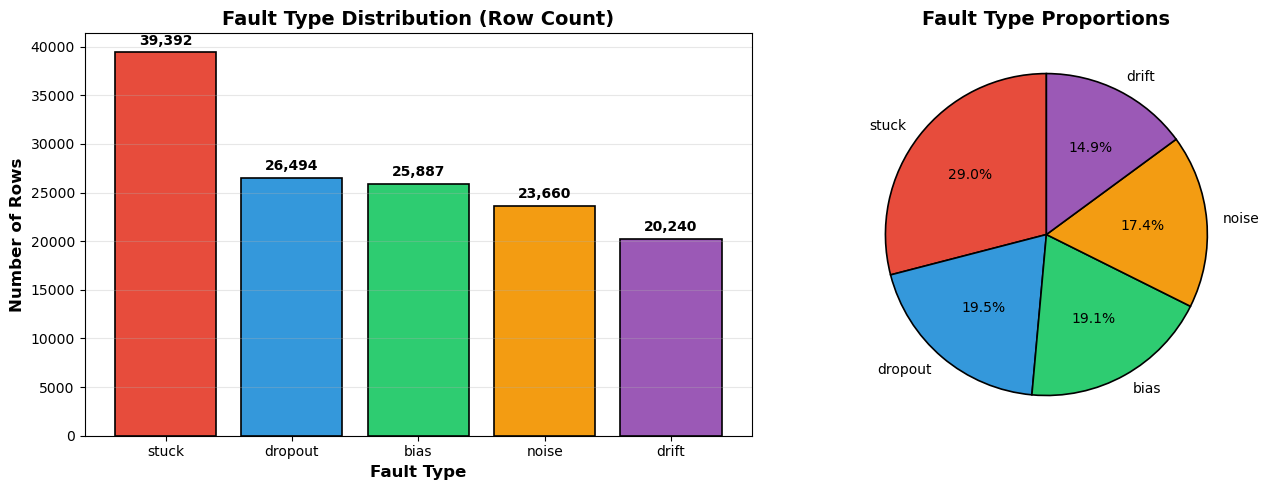

 Saved: fault_distribution_20260221_135449_utc.png


In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart: Rows per fault type
fault_counts = df_injected[df_injected['label'] == 2]['fault_type'].value_counts()
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']
ax1.bar(fault_counts.index, fault_counts.values, color=colors, edgecolor='black', linewidth=1.2)
ax1.set_xlabel('Fault Type', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Rows', fontsize=12, fontweight='bold')
ax1.set_title('Fault Type Distribution (Row Count)', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(fault_counts.values):
    ax1.text(i, v + 500, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Pie chart: Proportion of each fault type
ax2.pie(fault_counts.values, labels=fault_counts.index, autopct='%1.1f%%', 
        colors=colors, startangle=90, wedgeprops={'edgecolor': 'black', 'linewidth': 1.2})
ax2.set_title('Fault Type Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(INJECT_DIR / f'fault_distribution_{RUN_ID}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f" Saved: fault_distribution_{RUN_ID}.png")

### Visualization 2 - Class Distribution Timeline

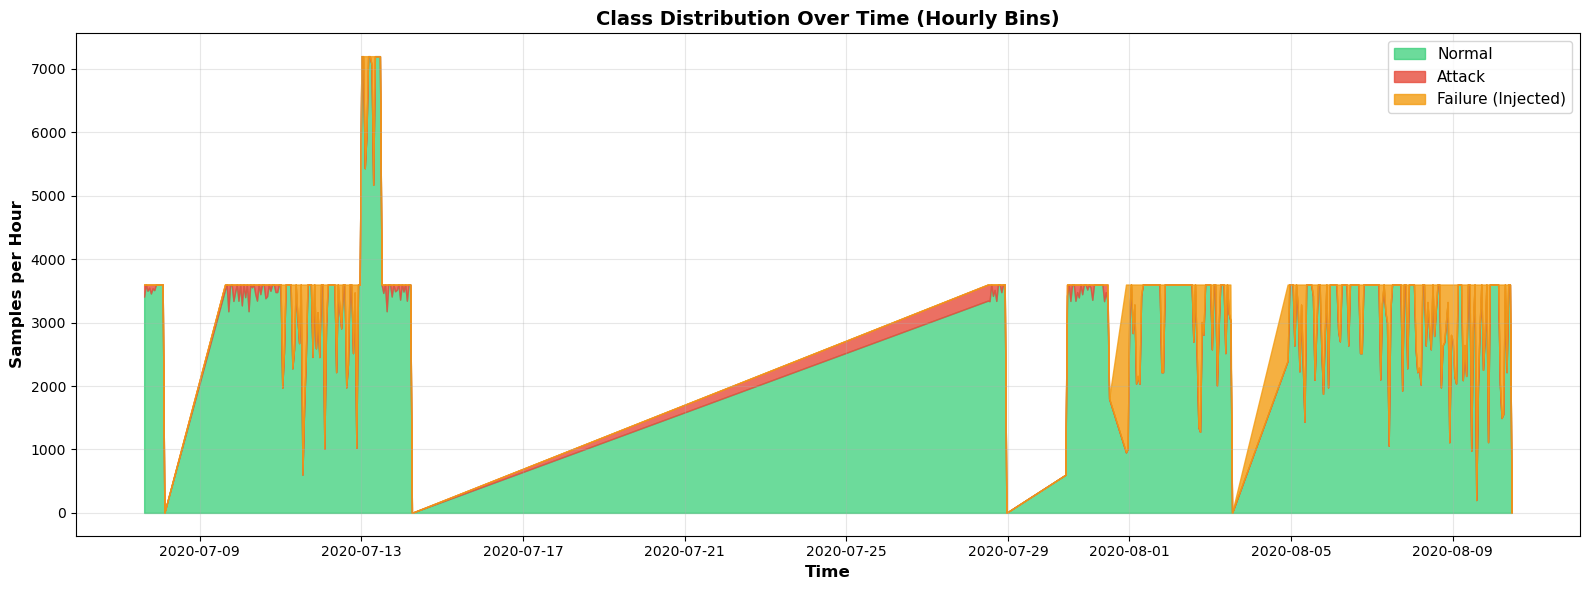

 Saved: temporal_distribution_20260221_135449_utc.png


In [31]:
# Resample to hourly bins to see temporal distribution
df_viz = df_injected[[TIMESTAMP_COL, 'label']].copy()
df_viz['hour'] = df_viz[TIMESTAMP_COL].dt.floor('1h')

# Count labels per hour
hourly_counts = df_viz.groupby(['hour', 'label']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(16, 6))

# Stacked area plot
ax.fill_between(hourly_counts.index, 0, hourly_counts[0], 
                label='Normal', color='#2ecc71', alpha=0.7)
ax.fill_between(hourly_counts.index, hourly_counts[0], 
                hourly_counts[0] + hourly_counts.get(1, 0),
                label='Attack', color='#e74c3c', alpha=0.8)
ax.fill_between(hourly_counts.index, hourly_counts[0] + hourly_counts.get(1, 0),
                hourly_counts[0] + hourly_counts.get(1, 0) + hourly_counts[2],
                label='Failure (Injected)', color='#f39c12', alpha=0.8)

ax.set_xlabel('Time', fontsize=12, fontweight='bold')
ax.set_ylabel('Samples per Hour', fontsize=12, fontweight='bold')
ax.set_title('Class Distribution Over Time (Hourly Bins)', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(INJECT_DIR / f'temporal_distribution_{RUN_ID}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f" Saved: temporal_distribution_{RUN_ID}.png")

### Visualization 3 - Injection Log Summary

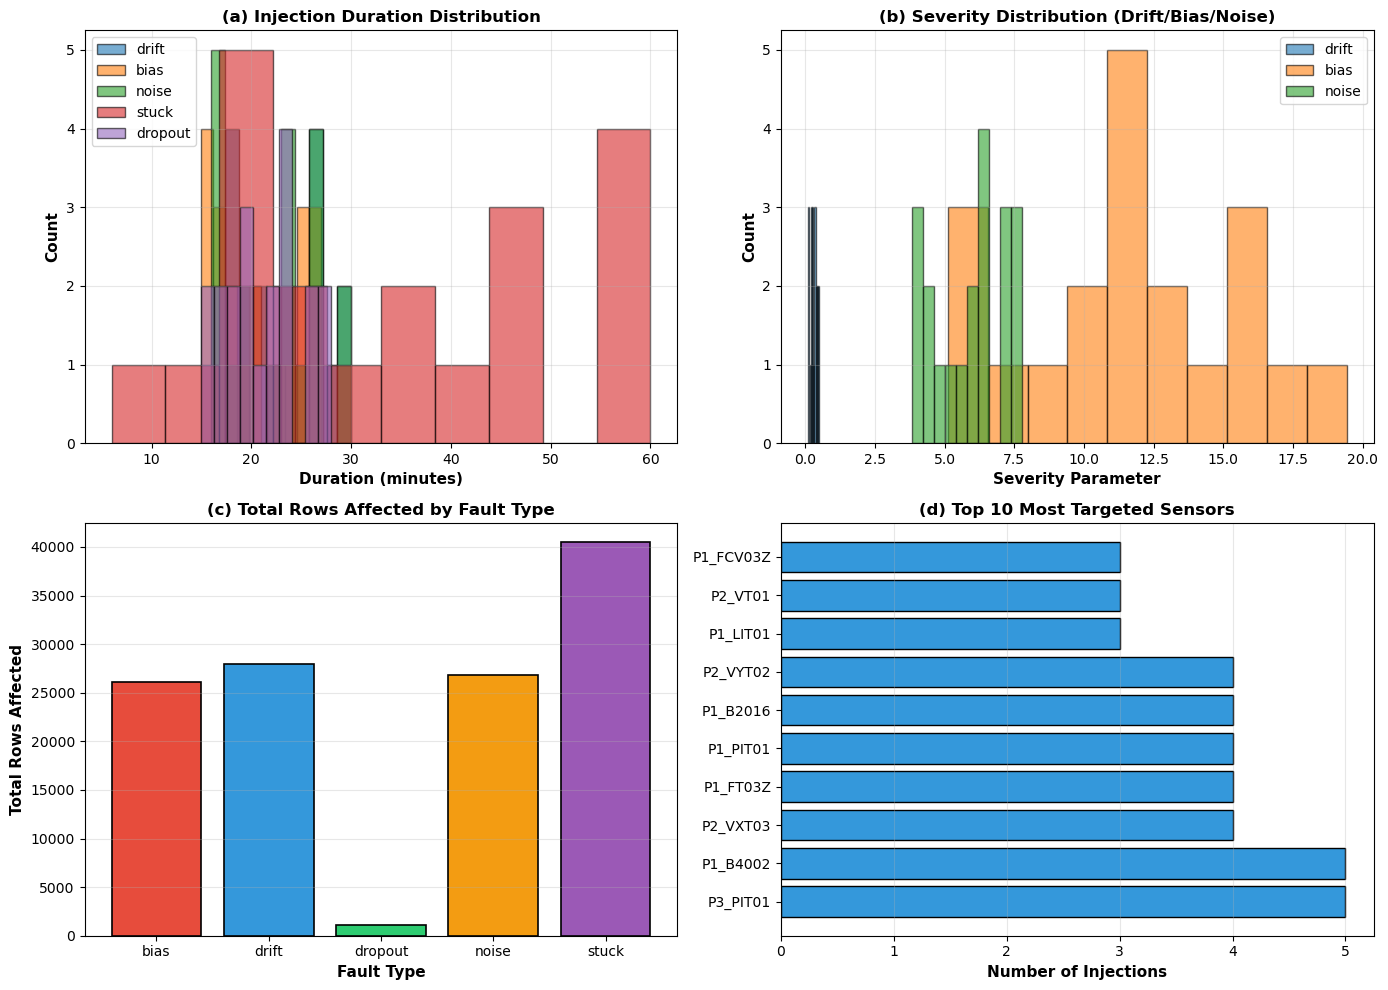

 Saved: injection_summary_20260221_135449_utc.png


In [32]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# (a) Duration distribution by fault type
for fault_type in injection_log['fault_type'].unique():
    data = injection_log[injection_log['fault_type'] == fault_type]['duration_min']
    axes[0, 0].hist(data, bins=10, alpha=0.6, label=fault_type, edgecolor='black')
axes[0, 0].set_xlabel('Duration (minutes)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Count', fontsize=11, fontweight='bold')
axes[0, 0].set_title('(a) Injection Duration Distribution', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# (b) Severity distribution by fault type
for fault_type in ['drift', 'bias', 'noise']:
    data = injection_log[injection_log['fault_type'] == fault_type]['severity']
    axes[0, 1].hist(data, bins=10, alpha=0.6, label=fault_type, edgecolor='black')
axes[0, 1].set_xlabel('Severity Parameter', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Count', fontsize=11, fontweight='bold')
axes[0, 1].set_title('(b) Severity Distribution (Drift/Bias/Noise)', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# (c) Rows affected per injection
fault_type_rows = injection_log.groupby('fault_type')['rows_affected'].sum()
axes[1, 0].bar(fault_type_rows.index, fault_type_rows.values, 
               color=colors, edgecolor='black', linewidth=1.2)
axes[1, 0].set_xlabel('Fault Type', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Total Rows Affected', fontsize=11, fontweight='bold')
axes[1, 0].set_title('(c) Total Rows Affected by Fault Type', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# (d) Sensors targeted
sensor_counts = injection_log['sensor'].value_counts().head(10)
axes[1, 1].barh(range(len(sensor_counts)), sensor_counts.values, color='#3498db', edgecolor='black')
axes[1, 1].set_yticks(range(len(sensor_counts)))
axes[1, 1].set_yticklabels(sensor_counts.index)
axes[1, 1].set_xlabel('Number of Injections', fontsize=11, fontweight='bold')
axes[1, 1].set_title('(d) Top 10 Most Targeted Sensors', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(INJECT_DIR / f'injection_summary_{RUN_ID}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f" Saved: injection_summary_{RUN_ID}.png")

### Visualization 4 - Example Injection (pick one)

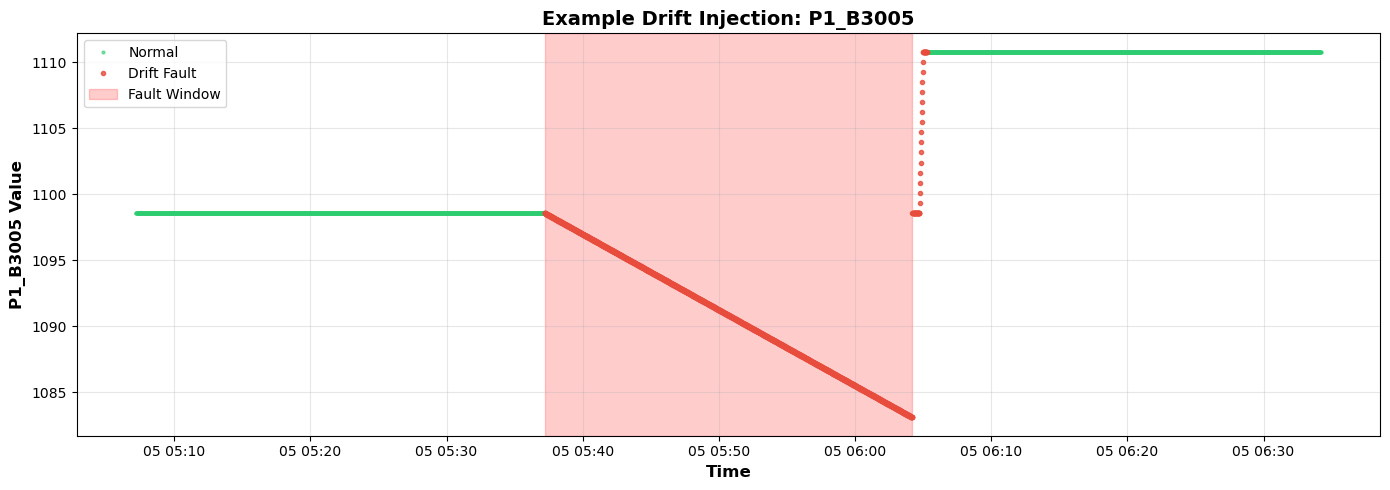

  Saved: example_injection_20260221_135449_utc.png

Example details:
  Sensor: P1_B3005
  Duration: 27 min
  Severity: 0.247% per minute
  Direction: down


In [33]:
# Pick an interesting injection to visualize (e.g., first drift)
example = injection_log[injection_log['fault_type'] == 'drift'].iloc[0]

sensor = example['sensor']
start = example['start_time']
end = example['end_time']

# Get a window around the injection (30 min before/after)
plot_start = start - pd.Timedelta(minutes=30)
plot_end = end + pd.Timedelta(minutes=30)

mask = (df_injected[TIMESTAMP_COL] >= plot_start) & (df_injected[TIMESTAMP_COL] <= plot_end)
plot_data = df_injected.loc[mask, [TIMESTAMP_COL, sensor, 'label']].copy()

fig, ax = plt.subplots(figsize=(14, 5))

# Plot sensor values colored by label
normal_mask = plot_data['label'] == 0
fault_mask = plot_data['label'] == 2

ax.plot(plot_data.loc[normal_mask, TIMESTAMP_COL], 
        plot_data.loc[normal_mask, sensor], 
        'o', markersize=2, color='#2ecc71', label='Normal', alpha=0.6)
ax.plot(plot_data.loc[fault_mask, TIMESTAMP_COL], 
        plot_data.loc[fault_mask, sensor], 
        'o', markersize=3, color='#e74c3c', label='Drift Fault', alpha=0.8)

# Shade fault window
ax.axvspan(start, end, alpha=0.2, color='red', label='Fault Window')

ax.set_xlabel('Time', fontsize=12, fontweight='bold')
ax.set_ylabel(f'{sensor} Value', fontsize=12, fontweight='bold')
ax.set_title(f'Example Drift Injection: {sensor}', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(INJECT_DIR / f'example_injection_{RUN_ID}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"  Saved: example_injection_{RUN_ID}.png")
print(f"\nExample details:")
print(f"  Sensor: {sensor}")
print(f"  Duration: {example['duration_min']} min")
print(f"  Severity: {example['severity']:.3f}% per minute")
print(f"  Direction: {example.get('direction', 'N/A')}")

# From here move to the Dataset Pipeline Notebook, Section 3